# Importing and loading dataset

In [37]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from __future__ import print_function

# Performing K Mean Algorithm

In [55]:
fb_df = pd.read_csv("fb_transformed_data.csv")
print(fb_df.shape)
print(fb_df.head())

titles = list(fb_df['text'])
titles = titles[:1000]
print(str(len(titles)) + ' titles')

ranks = []

for i in range(0,len(titles)):
    ranks.append(i)
    
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(titles)

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)



num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

films = { 'title': titles, 'rank': ranks, 'synopsis': titles, 'cluster': clusters }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind].encode('utf-8', 'ignore'), end=',')
    print()

(33068, 3)
    post_date  ver                                               text
0  2014-09-24    3  yet anoth 5 unauthor sourc ip address read que...
1  2012-01-12    1  check use facebook android sdk graph api want ...
2  2016-01-26    3  facebook convers track valu predetermin event ...
3  2012-01-12    1  method like page via api possibl duplic 39like...
4  2017-04-30    3  encod gps coordin json object c sorri noobish ...
1000 titles
Wall time: 651 ms
(1000, 25)
Wall time: 1.8 s
Top terms per cluster:

Cluster 0 words: b'error', b'use', b'code', b'url', b'new', b'tri',
Cluster 1 words: b'post', b'use', b'like', b'app', b'api', b'graph',
Cluster 2 words: b'page', b'like', b'post', b'use', b'user', b'url',
Cluster 3 words: b'api', b'graph', b'graph api', b'use', b'user', b'return',
Cluster 4 words: b'user', b'app', b'use', b'access', b'need', b'work',


# Multi-dimensional modelling

In [56]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

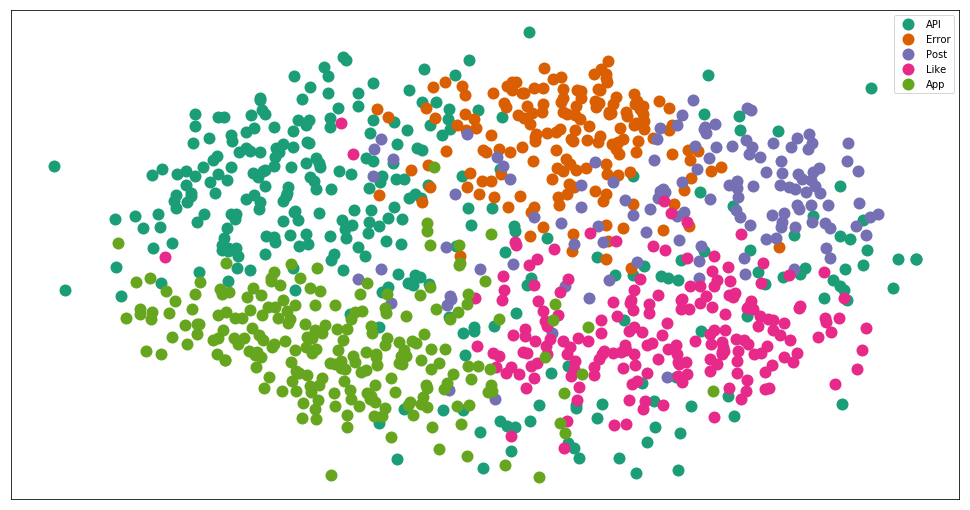

In [58]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'API', 
                 1: 'Error', 
                 2: 'Post', 
                 3: 'Like', 
                 4: 'App'}

%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point


    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.close()

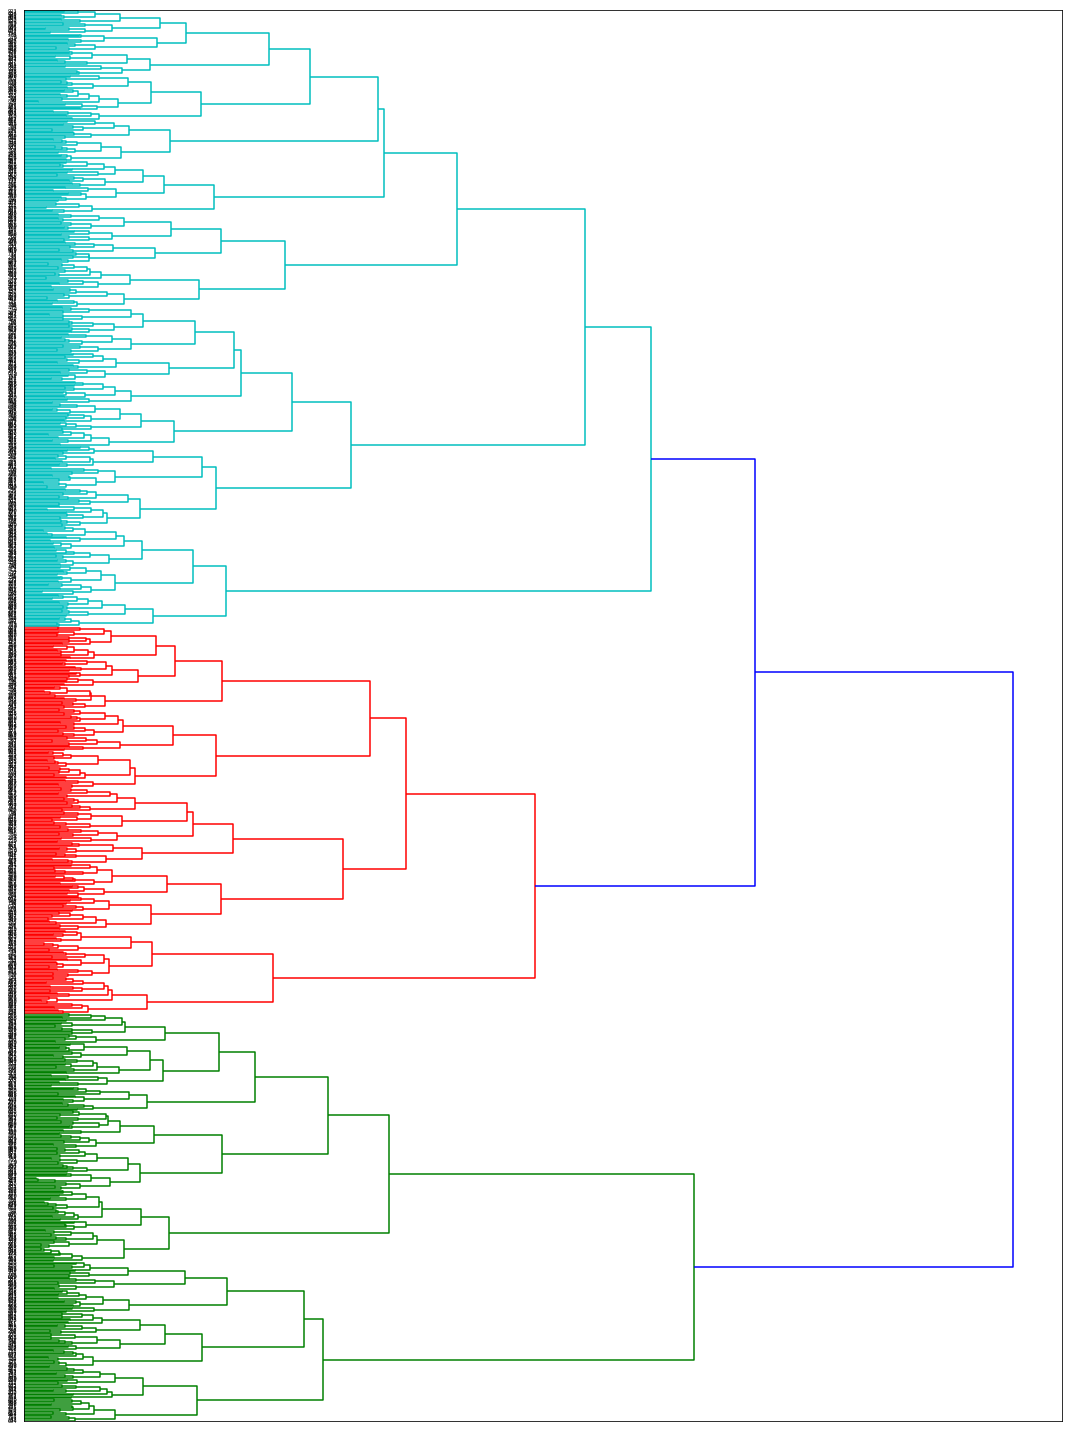

In [61]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [68]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

import nltk
nltk.download('punkt')


#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 
#remove proper names
preprocess = [strip_proppers(doc) for doc in titles]

%time tokenized_text = titles

%time texts = titles

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lambda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 0 ns
Wall time: 0 ns


In [69]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [72]:
texts[1]

'check use facebook android sdk graph api want check use facebook android sdk graph api tri string checkindata messagetest place000000000 coordinateslatitude000000000 longitude000000000 bundl param new bundl paramsputstringcheckin checkindata string pagedata tri pagedata facebookrequestcheckin param post catch except e eprintstacktrac systemprintlndata pagedata give error errormessagebatch paramet must json arraytypegraphbatchexcept correct way check use facebook graph api'